## Step 1: Load Required Libraries

In [1]:
# Import Libraries
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder  
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc  
import os  
import warnings 
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import chi2_contingency
warnings.filterwarnings('ignore')

## Step 2: Load Dataset

In [2]:
file_path = 'Heart Prediction Quantum Dataset.csv'  # Define the path to the CSV file
if os.path.exists(file_path):  # Check if the file exists
    df = pd.read_csv(file_path)  # Load CSV into DataFrame
else:
    raise FileNotFoundError(f"Dataset not found at {file_path}")  # Raise error if file is missing


## Step 3: Data Exploration And Data Preprocessing

In [3]:
print("Dataset Shape:", df.shape)  # Print number of rows and columns
print("\nFirst 5 Rows:")
df.head()  # Display first 5 records

Dataset Shape: (500, 7)

First 5 Rows:


,Age,Gender,BloodPressure,Cholesterol,HeartRate,QuantumPatternFeature,HeartDisease
0,68,1,105,191,107,8.362241,1
1,58,0,97,249,89,9.249002,0
2,44,0,93,190,82,7.942542,1
3,72,1,93,183,101,6.495155,1
4,37,0,145,166,103,7.653900,1


In [4]:
print("\nSummary Statistics:")
print(df.describe())  # Show summary stats of numeric columns
print(df.columns)  # Print all column names
df.rename(columns=lambda x: x.strip(), inplace=True)  # Remove extra spaces from column names
print(df.columns)  # Check column names again after stripping spaces


Summary Statistics:
              Age      Gender  BloodPressure  Cholesterol   HeartRate  \
count  500.000000  500.000000     500.000000    500.00000  500.000000   
mean    54.864000    0.468000     132.874000    221.50000   88.766000   
std     14.315004    0.499475      26.418516     43.86363   17.417289   
min     30.000000    0.000000      90.000000    150.00000   60.000000   
25%     43.000000    0.000000     111.000000    183.75000   73.000000   
50%     55.000000    0.000000     132.000000    221.00000   89.000000   
75%     66.250000    1.000000     155.000000    258.00000  104.000000   
max     79.000000    1.000000     179.000000    299.00000  119.000000   

       QuantumPatternFeature  HeartDisease  
count             500.000000    500.000000  
mean                8.317407      0.600000  
std                 0.919629      0.490389  
min                 6.164692      0.000000  
25%                 7.675779      0.000000  
50%                 8.323064      1.000000  
75%   

## Step 4: EDA (Exploratory Data Analysis)

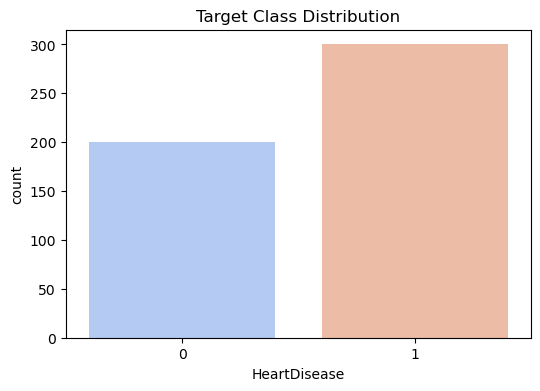

In [5]:
plt.figure(figsize=(6,4))
sns.countplot(x='HeartDisease', data=df, palette='coolwarm')  # Plot count of classes in target variable
plt.title('Target Class Distribution')
plt.show()


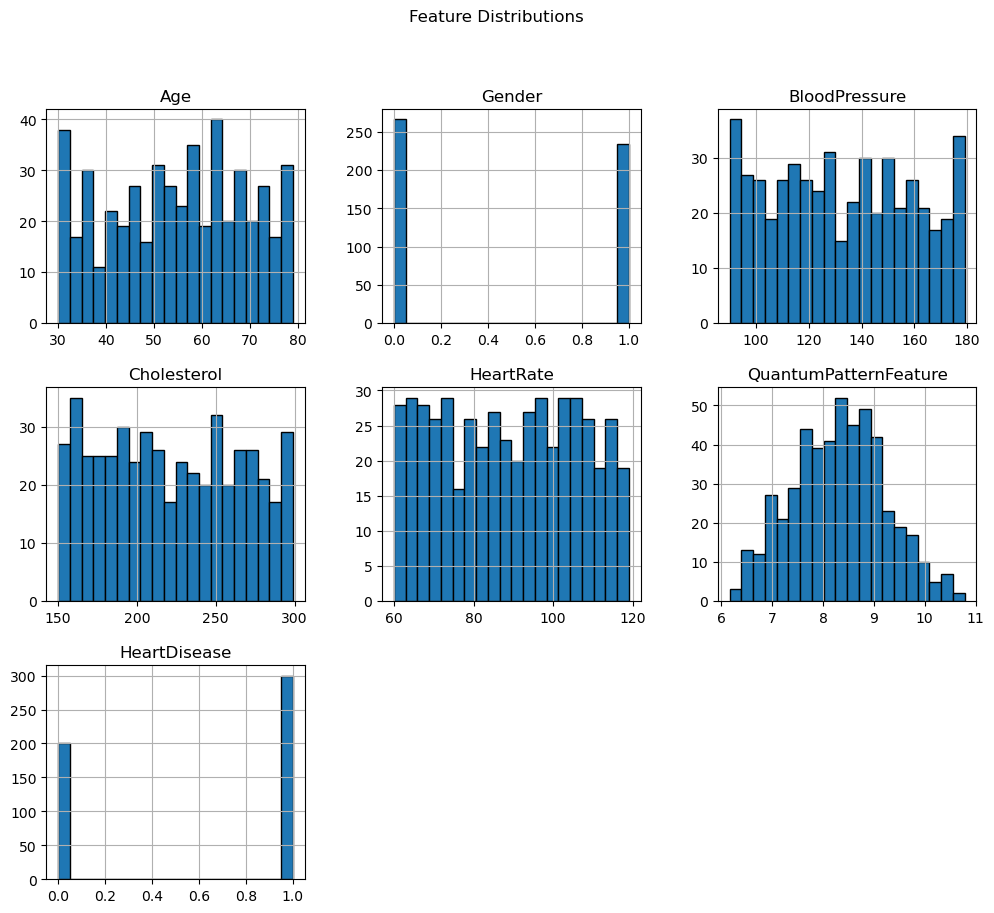

In [6]:
df.hist(figsize=(12,10), bins=20, edgecolor='black')  # Plot histograms for all numeric columns
plt.suptitle('Feature Distributions')
plt.show()


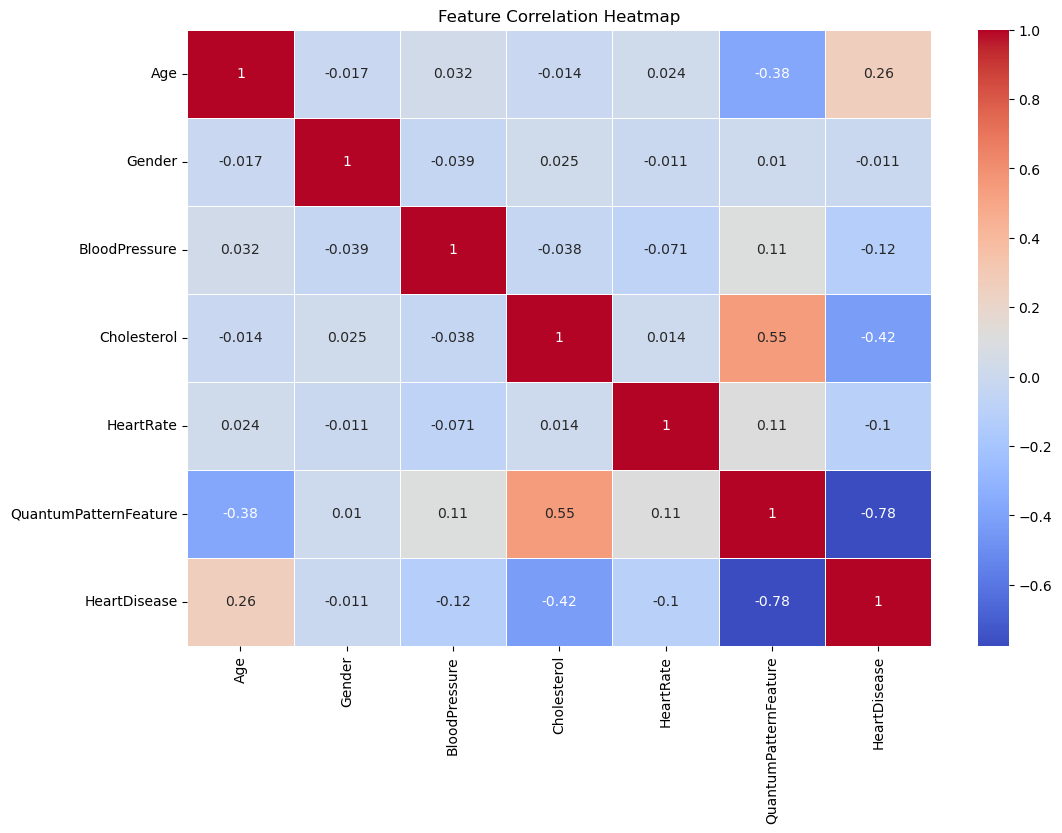

In [7]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)  # Correlation matrix
plt.title('Feature Correlation Heatmap')
plt.show()


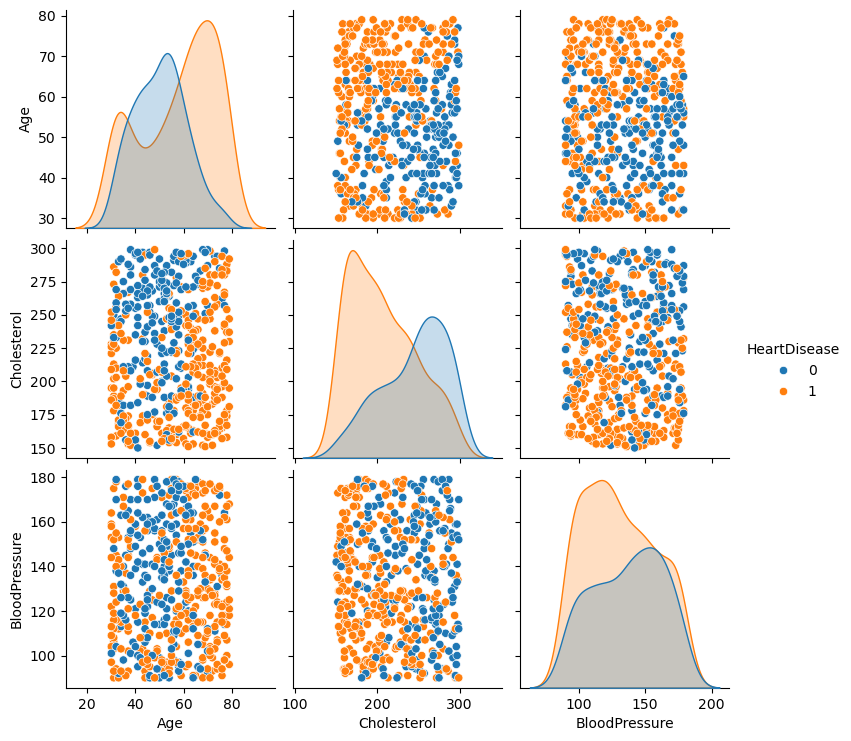

In [8]:
important_features = ['Age', 'Cholesterol', 'BloodPressure', 'HeartDisease']
sns.pairplot(df[important_features], hue='HeartDisease', diag_kind='kde')  # Pairwise relationships
plt.show()


In [9]:
# Outlier Analysis using IQR method
print("OUTLIER ANALYSIS BEFORE REMOVAL")

# Calculate IQR for numeric columns only
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Calculate bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"\nOriginal dataset shape: {df.shape}")
print(f"\nTotal number of rows: {len(df)}")

# Count outliers per column
outlier_counts = {}
outlier_rows = set()

for col in numeric_cols:
    outliers = (df[col] < lower_bound[col]) | (df[col] > upper_bound[col])
    count = outliers.sum()
    outlier_counts[col] = count
    if count > 0:
        outlier_rows.update(df[outliers].index.tolist())
        print(f"\n{col}:")
        print(f"  - Lower bound: {lower_bound[col]:.2f}")
        print(f"  - Upper bound: {upper_bound[col]:.2f}")
        print(f"  - Number of outliers: {count} ({count/len(df)*100:.2f}%)")
        print(f"  - Min value: {df[col].min():.2f}")
        print(f"  - Max value: {df[col].max():.2f}")

# Count rows with at least one outlier
rows_with_outliers = len(outlier_rows)
print(f"Rows with at least one outlier: {rows_with_outliers} ({rows_with_outliers/len(df)*100:.2f}%)")
print(f"Rows without outliers: {len(df) - rows_with_outliers} ({(len(df) - rows_with_outliers)/len(df)*100:.2f}%)")


OUTLIER ANALYSIS BEFORE REMOVAL

Original dataset shape: (500, 7)

Total number of rows: 500
Rows with at least one outlier: 0 (0.00%)
Rows without outliers: 500 (100.00%)


## Step 5: Feature Engineering

In [10]:
label_encoders = {}  # Dictionary to store label encoders
for column in df.select_dtypes(include=['object']).columns:  # Loop through object-type columns
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])  # Encode each categorical feature
    label_encoders[column] = le  # Save the encoder


In [11]:
scaler = StandardScaler()  # Initialize standard scaler
df_scaled = pd.DataFrame(
    scaler.fit_transform(df.drop(columns=['HeartDisease'])),  # Scale features
    columns=df.drop(columns=['HeartDisease']).columns  # Retain column names
)
df_scaled['HeartDisease'] = df['HeartDisease'].values  # Add target column back


In [12]:
X = df_scaled.drop(columns=['HeartDisease'])  # Feature matrix
y = df_scaled['HeartDisease']  # Target vector


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=36, stratify=y  # Split with stratification on target
)


In [14]:
age_bins = [0, 30, 40, 50, 60, 70, 100]  # Define age bins
age_labels = ['<30', '30-39', '40-49', '50-59', '60-69', '70+']  # Define labels for age bins
df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right = False)  # Create age groups
contingency_table = pd.crosstab(df['AgeGroup'], df['HeartDisease'])  # Create contingency table
chi2, p, dof, ex = chi2_contingency(contingency_table)  # Perform Chi-square test
print(contingency_table)  # Print contingency table
print(f"Chi-square Statistic: {chi2}, p-value: {p},")  # Print Chi-square test results

HeartDisease   0   1
AgeGroup            
30-39         35  61
40-49         56  28
50-59         72  44
60-69         28  81
70+            9  86
Chi-square Statistic: 95.11957209091617, p-value: 1.0747912559227498e-19,


## Step 6: Model Selection & Training

In [15]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier()
}


In [16]:
for name, model in models.items():  # Loop through models
    model.fit(X_train, y_train)  # Train model
    y_pred = model.predict(X_test)  # Predict on test set
    print(f"\n{name} Performance:")  # Print model name
    print(classification_report(y_test, y_pred))  # Print precision, recall, F1-score
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))  # Print confusion matrix



Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91        40
           1       0.93      0.95      0.94        60

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100

Confusion Matrix:
[[36  4]
 [ 3 57]]

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        40
           1       0.98      0.93      0.96        60

    accuracy                           0.95       100
   macro avg       0.94      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Confusion Matrix:
[[39  1]
 [ 4 56]]


## Step 7: Hyperparameter Tuning for Random Forest

In [17]:
param_grid = {  # Define parameter grid
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')  # Grid search with 5-fold CV
grid_search.fit(X_train, y_train)  # Fit model on training data
print("Best Parameters:", grid_search.best_params_)  # Show best hyperparameters


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


## Step 8: Final Model Evaluation

In [18]:
best_model = grid_search.best_estimator_  # Retrieve best model from grid search
y_pred = best_model.predict(X_test)  # Predict on test set
print("\nFinal Model Performance:")
print(classification_report(y_test, y_pred))  # Show performance report



Final Model Performance:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93        40
           1       0.97      0.93      0.95        60

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



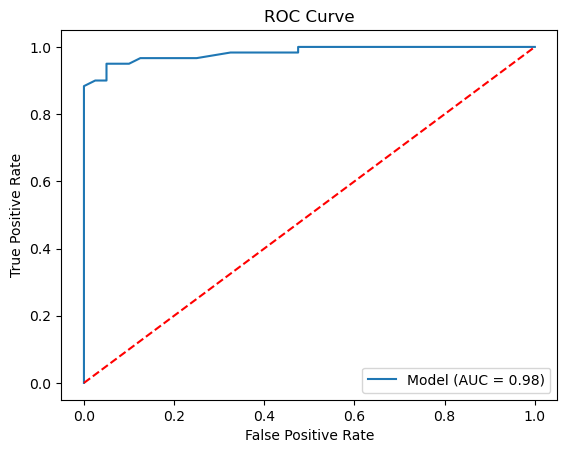

In [19]:
# Compute ROC curve values
fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1]) 
# Compute AUC
roc_auc = auc(fpr, tpr) 

# Plot the ROC curve for the model
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})') 

# Plot the diagonal baseline (random classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='red')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
